In [0]:
#я не торч просто дунул
import torch

In [0]:
#воспроизводимость
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
#данные
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

0it [00:00, ?it/s]

9920512it [00:02, 3948651.64it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 58415.36it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 863712.77it/s]                             
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 21512.52it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [0]:
X_train = X_train.float()
X_test = X_test.float()

In [0]:
X_train = X_train.reshape([-1, 28*28])
X_test = X_test.reshape([-1, 28*28])
X_train.shape

torch.Size([60000, 784])

In [0]:
import time
import numpy as np
from sklearn.metrics import accuracy_score

class MNISTNet_cpu(torch.nn.Module):
  def __init__(self, n_hidden_neurons, n_epochs=5000, lr=0.001, batch_size=100,
               save_history=False):
    super(MNISTNet_cpu, self).__init__()
    self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
    self.act1 = torch.nn.Sigmoid()
    self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)
    self.sm = torch.nn.Softmax(dim=1)
    
    self.n_epochs = n_epochs
    self.lr = lr
    self.batch_size = batch_size
    self.save_history = save_history
  
  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    return x
  
  def train(self, x, y):
    self.loss_history_ = []
    self.accuracy_history_ = []
    self.loss_history_test_ = []
    self.time_history_ = []
      
    optimizer = torch.optim.Adam(self.parameters(), self.lr)
    loss = torch.nn.CrossEntropyLoss() #принимает значения НЕ из Softmax (не вычисляется логарифм)
    
    start_time = time.time()
    for i in range(self.n_epochs):
      shuffled_indexes = np.random.permutation(x.shape[0])
      
      for start_index in range(0, x.shape[0], self.batch_size):
        x_batch = x[shuffled_indexes[start_index:start_index + self.batch_size]]
        y_batch = y[shuffled_indexes[start_index:start_index + self.batch_size]]
        optimizer.zero_grad()
        y_output = self.forward(x_batch)
        loss_value = loss(y_output, y_batch)
        loss_value.backward()
        optimizer.step()
    
      if self.save_history:
        self.loss_history_.append(loss(self.forward(x), y).detach().numpy())
        self.loss_history_test_.append(loss(self.forward(X_test), y_test).detach().numpy())

        #accuracy = accuracy_score(self.predict(x).detach().numpy(), y.detach().numpy())
        #self.accuracy_history_.append(accuracy)

        if i % 10 == 0:
          #print(accuracy)
          self.time_history_.append(time.time() - start_time)

        
    return self 

  def predict(self, x):
    return self.forward(x).argmax(dim=1)
  
  def predict_proba(self, x):
    return self.sm(self.forward(x))

In [0]:
#переведем на CUDA
torch.cuda.is_available()

True

In [0]:
!nvidia-smi

Sun Jul 21 18:13:50 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P8    30W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
X_test_cuda = X_test.to(device)
y_test_cuda = y_test.to(device)

In [0]:
class MNISTNet_gpu(torch.nn.Module):
  def __init__(self, n_hidden_neurons, n_epochs=5000, lr=0.001, batch_size=100,
               save_history=False):
    super(MNISTNet_gpu, self).__init__()
    self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
    self.act1 = torch.nn.Sigmoid()
    self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)
    self.sm = torch.nn.Softmax(dim=1)
    
    self.n_epochs = n_epochs
    self.lr = lr
    self.batch_size = batch_size
    self.save_history = save_history
  
  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    return x
  
  def train(self, x, y):
    self.loss_history_ = []
    self.accuracy_history_ = []
    self.time_history_ = []
    self.loss_history_test_ = []
    
    optimizer = torch.optim.Adam(self.parameters(), self.lr)
    loss = torch.nn.CrossEntropyLoss() #принимает значения НЕ из Softmax (не вычисляется логарифм)
    
    start_time = time.time()
    for i in range(self.n_epochs):
      shuffled_indexes = np.random.permutation(x.shape[0])
      
      for start_index in range(0, x.shape[0], self.batch_size):
        x_batch = x[shuffled_indexes[start_index:start_index + self.batch_size]].to(device)
        y_batch = y[shuffled_indexes[start_index:start_index + self.batch_size]].to(device)
        
        optimizer.zero_grad()
        y_output = self.forward(x_batch)
        loss_value = loss(y_output, y_batch)
        loss_value.backward()
        optimizer.step()
      
      if self.save_history:
        self.loss_history_.append(loss(self.forward(x), y).cpu().detach().numpy())
        self.loss_history_test_.append(loss(self.forward(X_test_cuda), y_test_cuda).cpu().detach().numpy())

        #accuracy = accuracy_score(self.predict(X_test_cuda).cpu().numpy(), y_test_cuda.cpu().detach().numpy())
        #self.accuracy_history_.append(accuracy)
        
        if i % 10 == 0:
          #print(accuracy)
          self.time_history_.append(time.time() - start_time)
        
    return self 

  def predict(self, x):
    return self.forward(x).argmax(dim=1)
  
  def predict_proba(self, x):
    return self.sm(self.forward(x))

In [0]:
mnist_net_gpu = MNISTNet_gpu(200, n_epochs=100, save_history=True)
mnist_net_gpu.to(device)

MNISTNet_gpu(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (act1): Sigmoid()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (sm): Softmax()
)

In [0]:
mnist_net_gpu.train(X_train.to(device), y_train.to(device))

0.9082
0.9313
0.9373
0.9415
0.9465
0.951
0.9438
0.9534
0.9541
0.9535


MNISTNet_gpu(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (act1): Sigmoid()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (sm): Softmax()
)

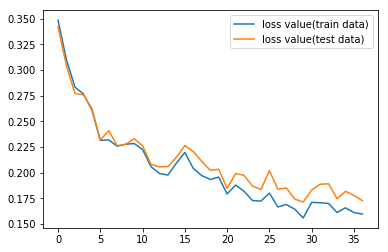

In [0]:
import matplotlib.pyplot as plt
plt.plot(range(len(mnist_net_gpu.loss_history_)), mnist_net_gpu.loss_history_, 
         label='loss value(train data)')
plt.plot(range(len(mnist_net_gpu.loss_history_test_)), mnist_net_gpu.loss_history_test_,
         label='loss value(test data)')
plt.legend();


In [0]:
#ускорение работы (cpu vs gpu)
mnist_net_cpu = MNISTNet_cpu(90, n_epochs=91, save_history=True)
mnist_net_gpu = MNISTNet_gpu(90, n_epochs=91, save_history=True)
mnist_net_gpu.to(device)

mnist_net_cpu.train(X_train, y_train)
mnist_net_gpu.train(X_train.to(device), y_train.to(device))


MNISTNet_gpu(
  (fc1): Linear(in_features=784, out_features=90, bias=True)
  (act1): Sigmoid()
  (fc2): Linear(in_features=90, out_features=10, bias=True)
  (sm): Softmax()
)

[2.4926342964172363, 26.336905241012573]


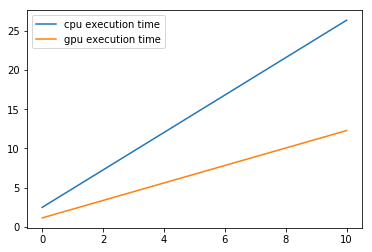

In [0]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0, 90, 10), np.array(mnist_net_cpu.time_history_), label='cpu execution time')
plt.plot(np.arange(0, 90, 10), np.array(mnist_net_gpu.time_history_), label='gpu execution time')
plt.legend();

In [0]:
#Замедляет ли torch.backends.cudnn.deterministic = True обучение на практике? Если да, то насколько?
torch.backends.cudnn.deterministic = True
mnist_net = MNISTNet_gpu(90, n_epochs=50)
mnist_net.to(device)
start_time = time.time()
mnist_net.train(X_train, y_train)
det_time = start_time - time.time()

torch.backends.cudnn.deterministic = False
mnist_net = MNISTNet_gpu(90, n_epochs=50)
mnist_net.to(device)
start_time = time.time()
mnist_net.train(X_train, y_train)
nondet_time = start_time - time.time()

print(det_time, nondet_time, sep='\n')